# Comparing Regression Algorithms - Part 3, Machine Learning

### Machine Learning

In computer science, we try to make algorithms faster. There are several ways we can get a speedup:

- Rewrite our algorithm so that it's faster
- Use technology that allows us to do more than one computation at once (parallelization)
- Use technology specifically designed to perform the types of calculations we need faster (specialization)

For this notebook, we will be using Google's TensorFlow machine learning toolkit. To install the TensorFlow package, open a terminal and type:

`pip install --upgrade tensorflow`

You will not need TensorFlow until you get to the bottom of this notebook.

### Stuff from last time

Let's get the most useful functions from the previous notebook.

In [2]:
import numpy as np
import time

cheat_W = 2
cheat_b = -4

starting_value = 2
ending_value = 8
num_values = 40

def make_vals(starting_value, ending_value, num_values):
    # Let's make a bunch of x values
    x_vals = np.linspace(starting_value, ending_value, num_values)
    # Let's make a bunch of y values close to our equation, but randomly off by a small amount
    noise = np.random.uniform(-1, 1, 40)
    target_loss = np.sum(np.square(noise))
    y_vals = cheat_W * x_vals + cheat_b + noise
    return x_vals, y_vals, abs(target_loss)

def measure_time(algorithm, steps):
    start = time.time()
    algorithm(steps)
    return time.time() - start

def generate_plane(a, b, c, noise):
    # Make an array of tuples of (x, y, z)
    coords = [(x , y, (a * x + b * y) / -c) for x in np.linspace(0, 10, 20) for y in np.linspace(0, 10, 20) ]
    # Return the "unzipped" tuples in 3 separate arrays
    x_vals, y_vals, z_vals = zip(*coords)
    # Add some noise to z
    z_vals += np.random.uniform(-noise, noise, len(x_vals))
    return x_vals, y_vals, z_vals

x_vals, y_vals, target_loss = make_vals(starting_value, ending_value, num_values)

# Let's cheat again, and use numpy's built in linear regression
start = time.time()
target_W, target_b = np.linalg.lstsq(np.vstack([x_vals, np.ones(len(x_vals))]).T, y_vals)[0]
print "Cheating time:", time.time() - start

print "Target loss:", target_loss
print "Target W:", target_W
print "Target b:", target_b

Cheating time: 0.000645875930786
Target loss: 12.9213944595
Target W: 1.99152388146
Target b: -3.92302803324


### TensorFlow

Let's rewrite our regression algorithm to use machine learning to perform the regression. We will use Google's TensorFlow package. First, we will create the variables for `W` and `b`, that we are attempting to find through regression. In addition, we will create placeholders `x` and `y` where we can feed in our `x_vals` and `y_vals`.

In [3]:
import tensorflow as tf

# Make TesnorFlow variables W and b, with some really bad guesses to begin with
W = tf.Variable([.3])
b = tf.Variable([-.3])

# Make placeholders where regression data can go
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

### Equation graphs

TensorFlow represents all of its operations, including each operation in an equation, as an interconnected graph of variables, placeholders and operations. TensorFlow makes this really easy.

In [4]:
linear  = W * x + b
loss = tf.reduce_sum(tf.square(linear - y))

### Optimization

TensorFlow has built in optimization operation nodes. The optimizer does something interesting - it computes the effect of change in any of the input variables `W` and `b` using derivatives (from Calculus!) and tries to minimize the loss every time the `optimizer` is run.

In [5]:
optimizer = tf.train.GradientDescentOptimizer(0.0001).minimize(loss)

In [6]:
losses = None
Ws = None
bs = None

def gradient_regression(epochs):
    global losses
    global Ws
    global bs
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    data = { x : x_vals.tolist(), y: y_vals.tolist() }
    for i in range(epochs):
        _, output_loss, output_W, output_b = session.run([optimizer, loss, W, b], feed_dict=data)
        losses[i] = output_loss
        Ws[i] = output_W[0]
        bs[i] = output_b[0]
    #print "loss:", output_loss
    #print "Equation: y =", session.run([W])[0][0], " * x +", session.run([b])[0][0]

steps = 10000
losses = steps * [ 0.0 ]
Ws = steps * [ 0.0 ]
bs = steps * [ 0.0 ]
execution_time = measure_time(gradient_regression, steps)
print "Execution time:", execution_time


Execution time: 6.41488814354


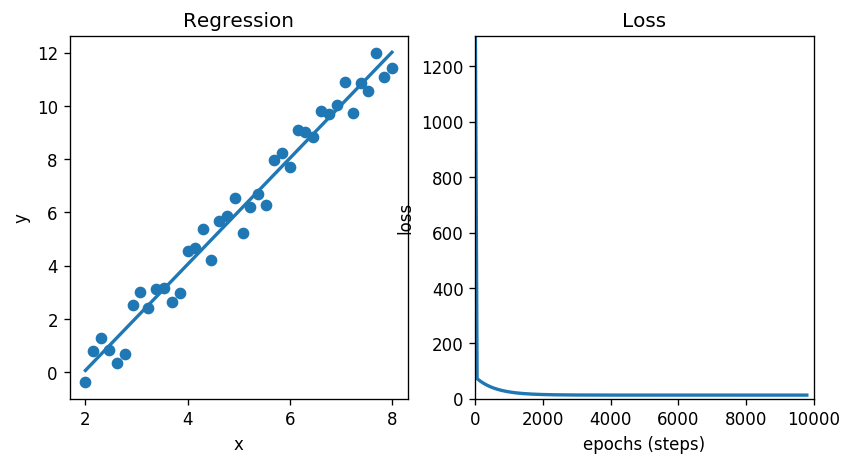

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(8, 4), dpi=120)

regression_axis = axes[0]
regression_axis.set_title("Regression")
regression_axis.set_xlabel("x")
regression_axis.set_ylabel("y")

regression_axis.scatter(x_vals, y_vals)
regression_line, = regression_axis.plot([], [], lw=2)

loss_axis = axes[1]
loss_axis.set_title("Loss")
loss_axis.set_xlabel("epochs (steps)")
loss_axis.set_ylabel("loss")
loss_axis.set_ylim([0, losses[0]])
loss_axis.set_xlim([0, steps])
loss_line, = loss_axis.plot([], [], lw=2)

def animate(frame):
    x = np.linspace(x_vals[0], x_vals[len(x_vals) - 1], 2)
    y = Ws[frame] * x + bs[frame]
    regression_line.set_data(x, y)
    loss_line.set_data(np.linspace(0, frame, frame / 50), losses[0:frame:50])

    return regression_line, loss_line

anim = animation.FuncAnimation(fig, animate, frames=range(0, steps, 200), interval=100, blit=True)

HTML(anim.to_html5_video())


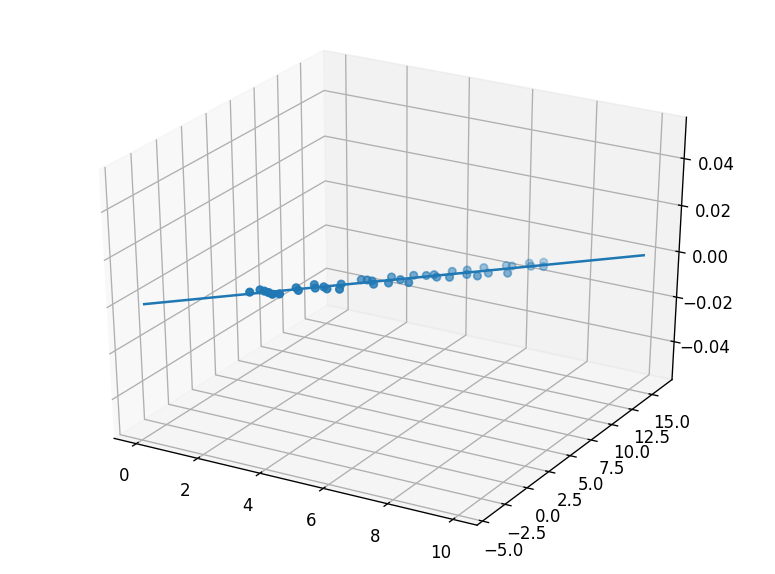

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure(num=None, figsize=(8, 6),dpi=120)
fig.canvas.draw()
axes = fig.add_subplot(111, projection='3d')
axes.scatter(xs=x_vals, ys=y_vals)
plot_x = np.linspace(0, 10, 5)
plot_y = target_W * plot_x + target_b
axes.plot(plot_x, plot_y)

###  Speedups through technology

`numpy` and it's sibling `scipy` are popular packages for working with large sets of numbers. They are extremely fast because they are written in C, built around traditional arrays. You may have wondered about some of the list operations that we perform using `numpy`. For example, if we are generating an array of `y` values with:

```
y = W * x + b
```

If the `x` array contains _*n*_ values, this single operation actually has complexity _*O(n)*_. However, we didn't include that in our overall complexity for previous algorithms simply because when we are comparing one linear regression algorithm to another, it's a performance cost that's present in all of them.

What about specialized hardware and parallelization? There are a lot of technologies that can be used to speed up these operations. Some technologies present in TACC hardware are:

##### SIMD (Single instruction, multiple data):

Most modern processors have some type of SIMD functionality built in. If you are going to multiply every element of an array by W, then SIMD allows you to multiply every element in an array simultaneously in the same time it would take to multiply a single element.

##### GPGPU (General purpose graphics processing unit):

3D graphics in video games are created with 3D polygon data. To quickly perform the matrix operations necessary to render the graphics, companies like NVIDIA created video hardware with specialized graphics processing units (GPUs) that perform these operations extremely quickly. Later on, researchers started exploiting these GPUs to perform non-graphics matrix operations (because a lot of complex mathematics can be represented with matrices.) This technology eventually becamse General Purpose GPU.

##### Parallelization:

At TACC, machines like [Stampede](https://www.tacc.utexas.edu/stampede/) are built with thousands of individual self contained computers, called nodes. Each node also contains dozens of individual processing cores. By writing code that distributes the workload between multiple nodes and cores, we can divide up a single task and perform each portion in parallel.